### This notebook aims to predict whether a product is a failure or not based on some measurement,attribute and loading variables. The dataset was used in Kaggle Tabular _Playgorund Series-August22_ . The dataset can be found [here](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/data?select=train.csv)

# Importing Libraries 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore,Back,Style 
import scipy.stats
import warnings


# Loading the Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train)
display(test)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,E,158.95,material_7,material_6,6,9,6,16,4,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,26566,E,146.02,material_7,material_6,6,9,10,12,8,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,26567,E,115.62,material_7,material_6,6,9,1,10,1,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0
26568,26568,E,106.38,material_7,material_6,6,9,2,9,4,...,11.392,17.064,17.814,14.928,16.273,15.485,13.624,12.865,730.156,0


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,I,144.74,material_7,material_5,9,5,0,4,9,...,18.573,11.691,NaN,19.771,11.562,17.246,15.131,15.209,NaN,696.466
20771,47341,I,74.53,material_7,material_5,9,5,4,8,7,...,17.917,10.980,16.027,15.694,13.564,15.494,15.296,13.812,16.501,613.249
20772,47342,I,67.73,material_7,material_5,9,5,10,11,2,...,19.630,10.436,16.137,20.612,11.134,16.519,15.525,14.175,17.728,783.349
20773,47343,I,126.15,material_7,material_5,9,5,8,16,11,...,19.575,12.672,15.422,19.496,9.319,15.817,17.403,16.437,15.179,745.210


In [5]:
both = pd.concat([train[test.columns],test])

## Target Column

In [6]:
print(train['failure'].value_counts()/len(train))

0    0.787392
1    0.212608
Name: failure, dtype: float64


We can see that the target column is a bit unbalanced as 79 products are good and 21 are not. To in this case _Stratified Cross Validation_ will be used.

## Float columns

The dataset consists of 16 float columns. All the columns have missing values (up to 10%)

**Insight:** We'll need to impute the missing values (unless we use a classifier which deals with missing values automatically). The simplest solution is filling the missing values with the columns's mean, but this simple solution won't be effective. A more dophisticatec solution might use the imputers from [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) or even some customization imputation scheme

In [13]:
float_cols = [f for f in train.columns if train[f].dtype == float]
# float_col = [f for f in train.select_dtypes('float')]  #provides similar result 

In [20]:
pd.concat([train[float_cols].isnull().sum().rename('missing values in train'), test[float_cols].isnull().sum().rename('missing values in test')], axis=1)

,missing values in train,missing values in test
loading,250,223
measurement_3,381,329
measurement_4,538,409
measurement_5,676,508
measurement_6,796,624
measurement_7,937,720
measurement_8,1048,846
measurement_9,1227,904
measurement_10,1300,1067
measurement_11,1468,1136


In [42]:
print(f"{both[float_cols].isna().any(axis=1).sum()/len(both):.0%}")

54%


**Insight:** As there's over 50% of samples with missing values, the aim will be to impute effectively. 


The histogram of the float features are given below. 

Text(0.5, 1.04, 'Train and test distributions of the continuous features')

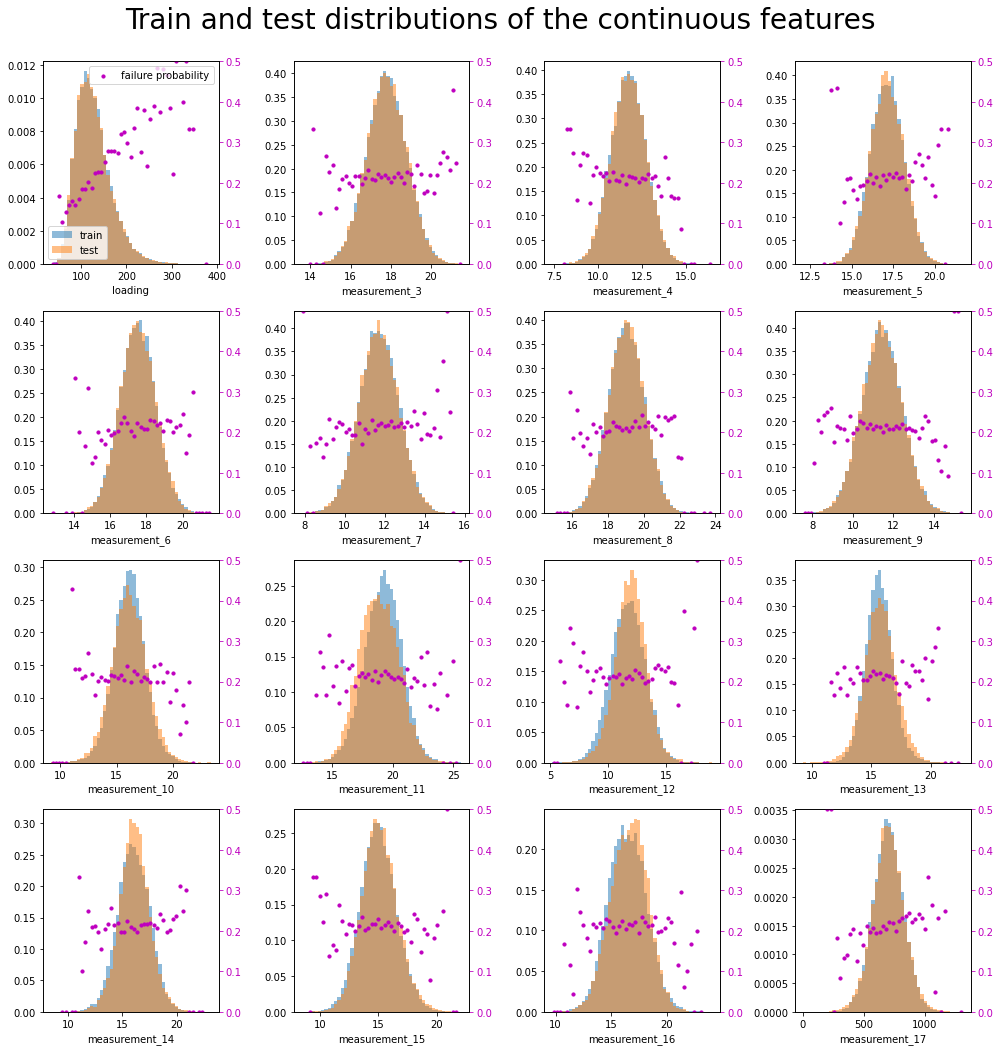

In [59]:
_, axs = plt.subplots(4,4, figsize=(14,14))
for f, ax in zip(float_cols, axs.ravel()):
    mi = min(train[f].min(), test[f].min())
    ma = max(train[f].max(), test[f].max())
    bins = np.linspace(mi,ma,50)
    ax.hist(train[f], bins=bins, alpha = 0.5, density=True, label='train')
    ax.hist(test[f], bins=bins, alpha = 0.5, density=True, label='test')
    ax.set_xlabel(f)
    if ax == axs[0,0]: ax.legend(loc='lower left')

    ax2 = ax.twinx()
    total, _ = np.histogram(train[f], bins=bins)
    failures,_ = np.histogram(train[f][train.failure==1], bins=bins)
    with warnings.catch_warnings(): # ignore dividew by zero for empty bins
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        ax2.scatter((bins[1:] + bins[:-1]) / 2, failures/total,
                    color='m', s=10, label='failure probability')

    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0,0]: ax2.legend(loc='upper right')
plt.tight_layout(w_pad =1)
plt.suptitle("Train and test distributions of the continuous features", fontsize = 28, y=1.04)